In [1]:
import numpy as np # importing the necessary libraries.
import math
import matplotlib.pyplot as plt
import sys

filename = 'LightCurve.csv'        # Name of your input file. Read in as an argument (Include '.csv'). #
delimiter = ','              # Character separating your columns.                                #
nheaderlines = 0              # Number of header lines in your csv file.                          #
nfooterlines = 0               # Number of footer lines in your csv file.    

# Read in data (Change the filename and delimiter to suit your data):
my_data = np.genfromtxt(filename, delimiter=delimiter, skip_header=nheaderlines, skip_footer=nfooterlines) 

# number of elements
start = 0
stop = 44

# Now save it to x and y variables:
time_val = my_data[start:stop, 0]
Mag_val = my_data[start:stop, 1] 
Mag_error = my_data[start:stop, 2]

c = Mag_val[0] # starting mag value


amplitude = np.std(Mag_val) # amplitude of wave == standard deviation of data 
print(amplitude)
print(Mag_val)

0.060228044077442415
[19.604      19.57866667 19.59400033 19.49533367 19.59100033 19.531667
 19.43333367 19.58933367 19.558667   19.532667   19.57800033 19.58833367
 19.535667   19.600667   19.65800033 19.681667   19.605667   19.595667
 19.58933367 19.616667   19.64733367 19.706667   19.69100033 19.67400033
 19.54500033 19.584667   19.574667   19.51433367 19.530667   19.56900033
 19.655667   19.62000033 19.74800033 19.63200033 19.635667   19.63033367
 19.606667   19.66100033 19.67500033 19.65700033 19.678667   19.59133367
 19.554667   19.58000033]


In [2]:
def sin_wave(period, time, phase_shift, const, amp): #function to create model waves 
    y = []
    t = time
    T = period
    A = amp
    B = const
    phi = phase_shift
    for i in range(0,len(time)):
        sin = A*np.sin(((2*np.pi)/T)*t[i] + phi) + B
        y.append(sin)
    
    return y

In [3]:
def create_periods(time): #creates range of reasonable periods 
    periods = []
    T = time[stop-1]
    while T > 3600: #lower bound relates to shortest reasonable period
        periods.append(T)
        T = T-1
    return periods

In [4]:
def create_phase_shifts(): #function creates array of phase shits between -pi & pi
    phases = []
    incriment = np.pi/200 # incriment = smallest time bewteen data points 
    start = -1*np.pi
    end = np.pi
    phase = start
    phases.append(phase)
    while phase <= end:
        phase = phase + incriment
        phases.append(phase)
    return phases

In [5]:
def calculate_chi_squared(theoretical, real, uncertainty): #function to calculate chi square of a model 
    R = real
    E = theoretical
    sigma = uncertainty 
    y = 0
    for i in range(0,len(E)):
        x = math.pow((R[i]-E[i]),2)/(math.pow(sigma[i],2))
        y = y + x
    chi_sqr = y/len(real)
    return chi_sqr

In [6]:
def sigma_clipping(data, time, errors): #sigma clipping function. returns data that has removed points beyond 3 sigma 
    m = np.mean(data)
    raw_sigma = np.std(data)
    new_sigma = raw_sigma
    sigma = new_sigma
    tolerance_level = (sigma-new_sigma)/(new_sigma)
    clipped_data = []
    clipped_data_time = []
    clipped_data_errors = []
    
    for i in range(0,len(data)):
        if (data[i] > m) and (data[i]-errors[i] < m+3*sigma):
            clipped_data.append(data[i])
            clipped_data_errors.append(errors[i])
            clipped_data_time.append(time[i])
        if (data[i] < m) and (data[i]+errors[i] > m-3*sigma):
            clipped_data.append(data[i])
            clipped_data_errors.append(errors[i])
            clipped_data_time.append(time[i])
    new_sigma = np.std(clipped_data)
    
    return np.array(clipped_data), np.array(clipped_data_errors), np.array(clipped_data_time), new_sigma

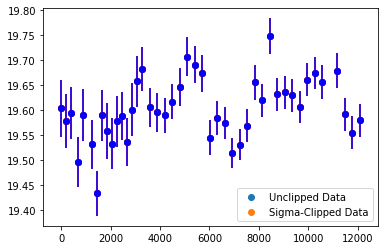

Original Standard Deviation =  0.060228044077442415
Clipped Standard Deviation = 0.060228044077442415


In [8]:
#sigma clipping data
clipped_mag = sigma_clipping(Mag_val, time_val, Mag_error)[0]
clipped_error = sigma_clipping(Mag_val, time_val, Mag_error)[1]
clipped_time = sigma_clipping(Mag_val, time_val, Mag_error)[2]
clipped_amp = sigma_clipping(Mag_val, time_val, Mag_error)[3]

#plot unclipped input 
plt.scatter(time_val, Mag_val)
plt.errorbar(time_val, Mag_val, yerr=Mag_error, fmt='o', c='r')

#plot clipped input 
plt.scatter(clipped_time, clipped_mag)
plt.errorbar(clipped_time, clipped_mag, yerr=clipped_error, fmt='o', c='b')


plt.legend(['Unclipped Data','Sigma-Clipped Data'], loc = 4,)
plt.show()
print('Original Standard Deviation = ', amplitude) 
print('Clipped Standard Deviation =',  clipped_amp)

In [10]:
periods = create_periods(time_val)
phase_shifts = create_phase_shifts()
models = [] #array of models 
chi_squared = [] #list of chi square of each model
phi = [] #phase shifts of best models

In [11]:
#this is the data crunch zone, where it all comes together 
for i in range(0,len(periods)):
    x = [] #place holder list to find best phase shift for each period i
    m = [] #place holder list for models
    for j in range(0,len(phase_shifts)): # loop to find best fit phase at a given period i
        model_sin = sin_wave(periods[i], clipped_time, phase_shifts[j], c, clipped_amp) 
        m.append(model_sin)
        y = calculate_chi_squared(model_sin, clipped_mag, clipped_error) #chi squared of a given phase with period i
        x.append(y)
    
    chi_squared_val = np.min(x)
    k = x.index(chi_squared_val) # index of best phase shift for a given period
    model = m[k] # best fit phase shift with period i 
    phi.append(phase_shifts[k])
    models.append(model)
    chi_squared.append(chi_squared_val)

In [12]:
min_chi = np.min(chi_squared) #best chi squared value
index = chi_squared.index(min_chi) #index of best chi squared value, this index also gives the best fit model and phase 
best_fit_period = periods[index]
best_fit_phase_shift = phi[index]
best_fit_model = np.array(models[index])

In [48]:
#loop to find error on period estimate
lower_lim_found = False
upper_lim_found = False
lower_bound = 0
upper_bound = 0

#rounding in loop is because chi squares will not be excatly equal to 2.71 
for i in range(0, len(chi_squared)):
    if round(chi_squared[i],3) == 2.710 and i < chi_squared.index(min_chi) and lower_lim_found == False: 
        upper_bound = periods[i]
        lower_lim_found = True
    if round(chi_squared[i],3) == 2.710 and i > chi_squared.index(min_chi) and upper_lim_found == False:
        lower_bound = periods[i]
        upper_lim_found = True
    if lower_lim_found == True and upper_lim_found == True:
        break

#upper and lower bounds are unlikely to be exactly the same so just taking the largest 
period_error1 = best_fit_period - lower_bound
period_error2 = upper_bound - best_fit_period
if period_error1 < period_error2:
    period_error = period_error2
elif period_error1 > period_error2:
    period_error = period_error1
else:
    period_error = period_error1

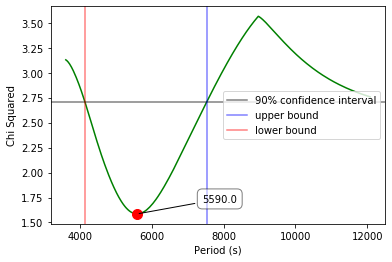

best fit period =  5590.0 +/- 1900.0 seconds
chi squared =  1.585684438510144


In [49]:
plt.xlabel('Period (s)')
plt.ylabel('Chi Squared')
plt.plot(periods, chi_squared, color = 'g')
plt.plot(best_fit_period, min_chi, lw=0, marker='o', color='r', markersize=10)
#plot chi squared distribution
plt.annotate(
        best_fit_period, 
        xy = (best_fit_period, min_chi), xytext = (100,10),
        textcoords = 'offset points', ha = 'right', va = 'bottom',
        bbox = dict(boxstyle = 'round, pad=0.5', fc = 'w', alpha = 0.5),
        arrowprops = dict(arrowstyle = '-', connectionstyle = 'arc3,rad=0'))

plt.axhline(y=2.71, color = 'k', alpha=0.5, label='90% confidence interval')
plt.axvline(x=(upper_bound), color = 'b', alpha=0.5, label='upper bound')
plt.axvline(x=lower_bound, color = 'r', alpha=0.5, label='lower bound')
plt.legend(loc=5)
plt.show()
print('best fit period = ', best_fit_period, '+/-' , round(period_error,-2), 'seconds') 
print('chi squared = ', min_chi)

#rounding due to resolution limit from phase shift of order 10^2 seconds

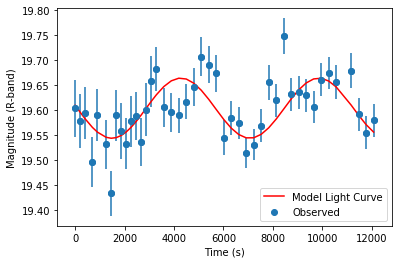

period =  1.5527777777777778 +/- 0.5277777777777778 hours
amplitude =  0.060228044077442415
chi squared =  1.585684438510144


In [52]:
#plot best fit model
plt.plot(clipped_time, best_fit_model, 'r')
plt.scatter(clipped_time, clipped_mag)
plt.errorbar(clipped_time, clipped_mag, yerr=clipped_error, fmt='o')
plt.xlabel('Time (s)')
plt.ylabel('Magnitude (R-band)')
plt.legend(['Model Light Curve', 'Observed',], loc = 4)
plt.show()


print('period = ', best_fit_period/(60*60), '+/-', round(period_error,-2)/(60*60), 'hours')
#print('phase_shift = ', best_fit_phase_shift, 'radians')
print('amplitude = ', clipped_amp)
print('chi squared = ', min_chi)

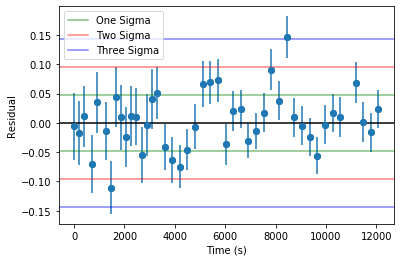

amplitude error = +\- 0.047867039677091314


In [54]:
#residual plot
residual = clipped_mag-best_fit_model
k = 0 #counter for residuals that lie within range of zero 
for i in range(0, len(residual)):
    if np.abs(residual[i]) <= 3*np.std(residual): #+ clipped_error[i]:
        k = k + 1

confidence = 100*k/len(residual) # percentage of residuals that lie in range of given sigma interval. can be printed if curious

plt.scatter(clipped_time, residual)
plt.xlabel('Time (s)')
plt.ylabel('Residual')
plt.errorbar(clipped_time, residual, yerr=clipped_error, fmt='o')
plt.axhline(y=0, color = 'k')

plt.axhline(y=np.std(residual), color = 'g', alpha=0.5, label='One Sigma')
plt.axhline(y=-np.std(residual), color = 'g', alpha=0.5)
plt.axhline(y=2*np.std(residual), color = 'r', alpha=0.5, label='Two Sigma')
plt.axhline(y=-2*np.std(residual), color = 'r', alpha=0.5)
plt.axhline(y=3*np.std(residual), color = 'b', alpha=0.5, label='Three Sigma')
plt.axhline(y=-3*np.std(residual), color = 'b', alpha=0.5)
plt.legend(loc=2)
plt.show()
